# 1: les packages

In [2]:
pip install instagram_private_api

Note: you may need to restart the kernel to use updated packages.


In [10]:
from instagram_private_api import Client, ClientCompatPatch
from pymongo import MongoClient
import requests # pour avoir une image de web
import shutil # pour sauvgarder une image locallement
from PIL import Image # bibliothèque de traitement d'images
import matplotlib.pyplot as plt # visualiser les images
import io


# 2: Connexion à Instagram

In [4]:
def conect_instagram(user_name,password):
  api = Client(user_name, password,auto_patch=True)
  return api

In [5]:
api=conect_instagram('aymenhmam','********')

# 3: Définir les Hashtags à chercher (le sujet du décès du président Jacques Chirac) 

In [19]:
hashtags1 = api.feed_tag('jacqueschiracmort',api.generate_uuid())
hashtags2 = api.feed_tag('mortjacqueschirac',api.generate_uuid())
hashtags3 = api.feed_tag('aurevoirjacqueschirac',api.generate_uuid())
hashtags4 = api.feed_tag('hommagejacqueschirac',api.generate_uuid())
hashtags5 = api.feed_tag('jacqueschirachommage',api.generate_uuid())
hashtags6 = api.feed_tag('jacqueschiracestmort',api.generate_uuid())
hashtags7 = api.feed_tag('jacqueschiracfuneral',api.generate_uuid())

# 4: Concaténation des dictionnaires des hashtags

In [21]:
def merge_hashtags(*hashtags):
    
    all_hashtags = {}
    for dict in hashtags:
        for key in dict:
            try:
                all_hashtags[key].append(dict[key])
            except KeyError:
                all_hashtags[key] = [dict[key]]
                
    return all_hashtags

# 5: Stocker les données dans la base MongoDB 

In [22]:
def insta_scrapper(hashtags):
    client=MongoClient()
    client=MongoClient('localhost',27017)
    client=MongoClient('mongodb://localhost:27017')
    db = client.hmamDB  #définier la base MongoDb
    mycol = db["publication"] #définier le nom de collection pour stocker les données dansMongoDb

    nb = 0  #conpteur pour compter le nombre des items ajouter
    
    for i in range (len(hashtags['items'])):
       
        for j in range (len(hashtags['items'][i])):
            
            url_image = hashtags['items'][i][j]['images']['standard_resolution']['url'] #récupérer URL de l'image
            text_image = hashtags['items'][i][j]['caption']['text'] #récupérer URL de l'image
            nb_comment = len(hashtags['items'][i][j]['preview_comments'])#récupérer le nombre des commentaires de l'image
            # parcourir tous les commentaires et les stoker dans une liste
            comments = []
            for k in range(nb_comment):
                comments.append(hashtags['items'][i][j]['preview_comments'][k]['text'])
            
            #télécharger l'image à partir de son url    
            r = requests.get(url_image, stream = True)
            filename="image.jpg"
            with open(filename,'wb') as f:
                shutil.copyfileobj(r.raw, f)

            # transformer l'image en bytes pour le stocker de MongoDB            
            im = Image.open(filename)
            image_bytes = io.BytesIO()
            im.save(image_bytes, format='JPEG')
        
            # stoker les données dans la base MongoDB
            data={"url":url_image,
                  'image': image_bytes.getvalue(),
                  "texte":text_image,
                  "commentaire":{"nombre": nb_comment,
                                 "liste_commentaire": comments
                                 }
              
                 }

            x = mycol.insert_one(data)
            nb+=1
    print('opération réussite')


In [23]:
all_hashtags = merge_hashtags(hashtags1,hashtags2,hashtags3,hashtags4,hashtags5,hashtags6,hashtags7)
insta_scrapper(all_hashtags)

opération réussite


# 6: connexion avec la base MongoDB 

In [24]:
client=MongoClient()
client=MongoClient('localhost',27017)
client=MongoClient('mongodb://localhost:27017')
db = client.hmamDB  #définier la base MongoDb
mycol = db["publication"] #définier le nom de collection pour stocker les données dansMongoDb

cursor = mycol.find()
entries = list(cursor)
print('{} items sont stockés'.format(len(entries)))

92 items sont stockés


# 7: récupérer une publication de la base

In [25]:
def item_description(entries,indice):
    pil_img = Image.open(io.BytesIO(entries[indice]['image']))
    plt.imshow(pil_img)
    plt.show()
    print(entries[indice]['texte'])
    print(entries[indice]['commentaire'])
    

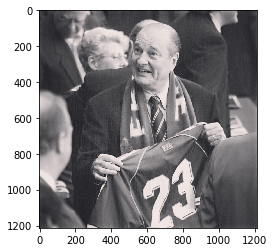

Aujourd’hui un grand monsieur est parti un air simple de plein de convictions et à l’écoute de sont peuples il restera le meilleur pour cette France , tu sera à jamais dans nôtres cœur et de notre mémoire merci pour tout ce que tu a pue réussir à faire pour la France je t’aime Jacques repose en paix 🇫🇷🔥🔥#hommagejacqueschirac#coupedumonde1998#homme politiquefrançais#26 septembre2019hommagenational🌹🥀 🇫🇷
{'nombre': 1, 'liste_commentaire': ['Mangez des pommes !!! XD']}


In [28]:
item_description(entries,55)